Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [2]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [40]:
# import block
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [41]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [42]:
df.dtypes

BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                float64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
APARTMENT_NUMBER                          object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int32
SALE_DATE           

In [43]:
# Filter down to only the subset we want to predict.
df = df.query("BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' & SALE_PRICE >= 100000 & SALE_PRICE <= 2000000")

In [44]:
df.shape

(3164, 21)

In [45]:
# changing sale date to datetime format
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [46]:
# Split into train and test
cutoff = pd.to_datetime('2019-04-01')
train = df.copy()[(df.SALE_DATE < cutoff)]
test = df.copy()[(df.SALE_DATE >= cutoff)]

In [47]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [48]:
# One-hots will blow up the feature count substantially.
# We can avoid this by creating new features that map categories of the old feature to a rank.
# The rank can be determined by the mean price for entries of that category.

# Let's try it with the neighborhood, and see if we can produce a general procedure.
hoodsort = train.groupby('NEIGHBORHOOD').SALE_PRICE.mean().sort_values().index.tolist()
ranks = [hoodsort.index(i) for i in hoodsort]
hoodmap = dict(zip(hoodsort,ranks))
train['NEIGHBORHOOD'].map(hoodmap).head(10)
# That'll do.

44     142
61      51
78     112
108    158
111     90
120    159
121    163
132    138
137    141
141    135
Name: NEIGHBORHOOD, dtype: int64

In [49]:
# Let's consider which features to do this for.
# It obviously only makes sense for categorical features.
# If the feature has only one unique value, there's no point.
# If the feature has a unique value count similar to the number of entries,
# it's closer to an ID than a category.
# Borough and neighborhood, we absolutely want.
# Tax class might be predictive, we may as well map it.
# Block and lot are specific to borough - a mapping of them alone won't work.
# Building class is likely predictive
# Address is basically an ID.
# Zip code is likely predictive
# We'll make a list of these features, loop through, and perform the above procedure.
# Then we'll create new features for each old one, named the same with _RANK appended.

mappingfeatures = ['BOROUGH','NEIGHBORHOOD','TAX_CLASS_AT_PRESENT','BUILDING_CLASS_AT_PRESENT',
                  'ZIP_CODE','BUILDING_CLASS_AT_TIME_OF_SALE']
for feature in mappingfeatures:
    sort = train.groupby(feature).SALE_PRICE.mean().sort_values().index.tolist()
    ranks = [sort.index(i) for i in sort]
    rankmap = dict(zip(sort,ranks))
    train[feature+'_RANK'] = train[feature].map(rankmap)
    test[feature+'_RANK'] = test[feature].map(rankmap)
    
test['NEIGHBORHOOD_RANK'].fillna(test['NEIGHBORHOOD_RANK'].mode()[0], inplace=True)
test['ZIP_CODE_RANK'].fillna(test['ZIP_CODE_RANK'].mode()[0], inplace=True)

In [50]:
# Correlations to price for training data

print('ZIP_CODE_RANK')
print(train['ZIP_CODE_RANK'].corr(train['SALE_PRICE']))
print('BOROUGH_RANK')
print(train['BOROUGH_RANK'].corr(train['SALE_PRICE']))
print('NEIGHBORHOOD_RANK')
print(train['NEIGHBORHOOD_RANK'].corr(train['SALE_PRICE']))
print('GROSS_SQUARE_FEET')
print(train['GROSS_SQUARE_FEET'].corr(train['SALE_PRICE']))

ZIP_CODE_RANK
0.6480772868453062
BOROUGH_RANK
0.2993331691131109
NEIGHBORHOOD_RANK
0.6953548966036663
GROSS_SQUARE_FEET
0.4533731447323735


In [51]:
# Correlations to price for testing data

print('ZIP_CODE_RANK')
print(test['ZIP_CODE_RANK'].corr(test['SALE_PRICE']))
print('BOROUGH_RANK')
print(test['BOROUGH_RANK'].corr(test['SALE_PRICE']))
print('NEIGHBORHOOD_RANK')
print(test['NEIGHBORHOOD_RANK'].corr(test['SALE_PRICE']))
print('GROSS_SQUARE_FEET')
print(test['GROSS_SQUARE_FEET'].corr(test['SALE_PRICE']))

ZIP_CODE_RANK
0.5576820562380824
BOROUGH_RANK
0.23695074028409716
NEIGHBORHOOD_RANK
0.5712964255916405
GROSS_SQUARE_FEET
0.4893549266792467


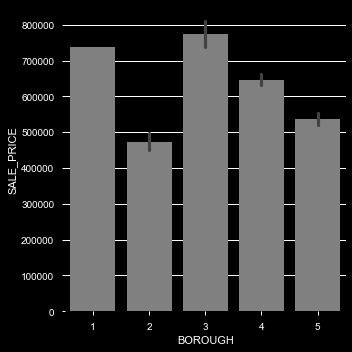

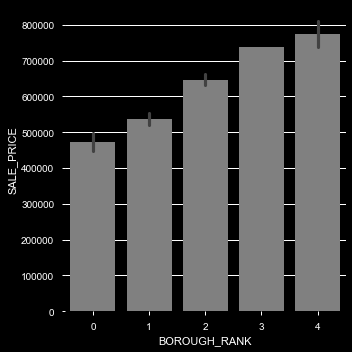

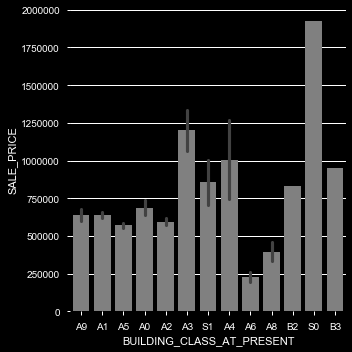

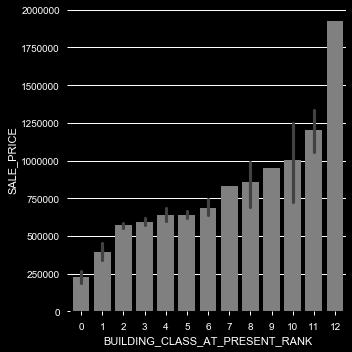

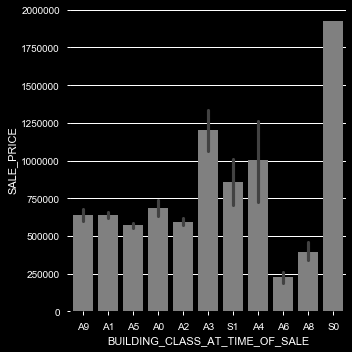

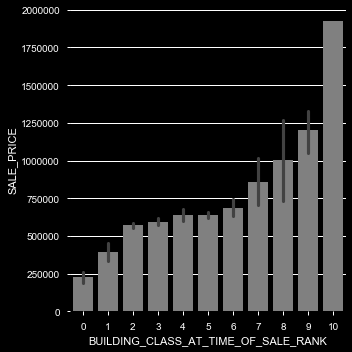

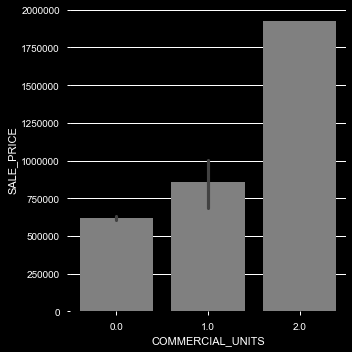

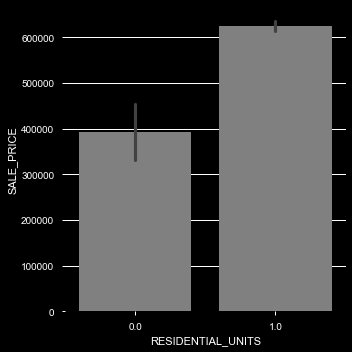

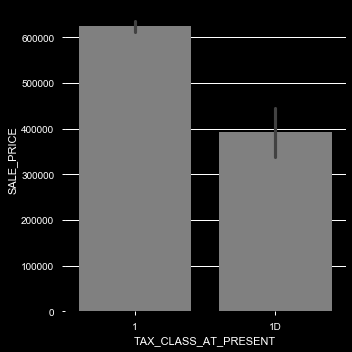

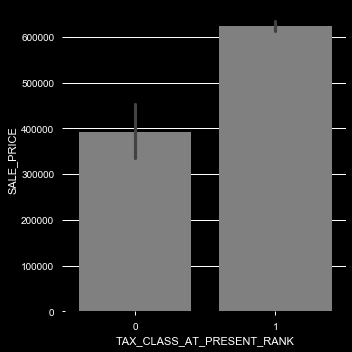

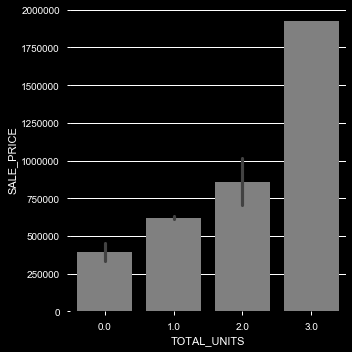

In [52]:
# Plots for categoryish data
for col in sorted(train.columns):
    if train[col].nunique() < 20 and train[col].nunique() > 1:
        sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
        plt.show()

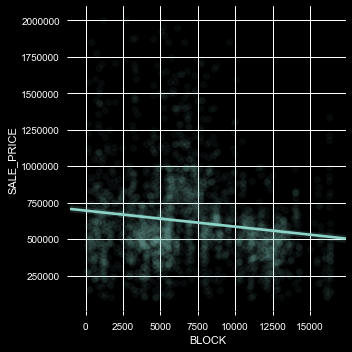

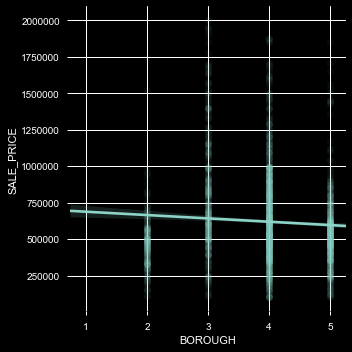

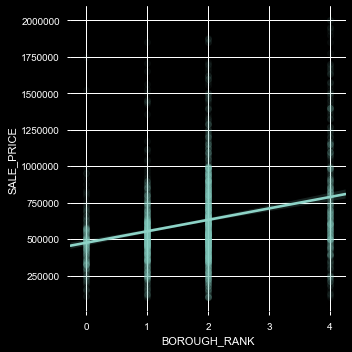

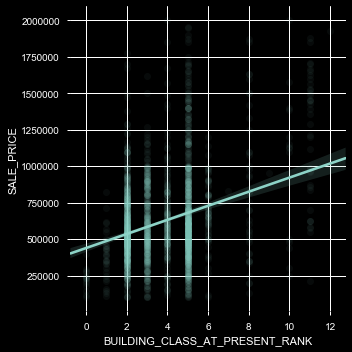

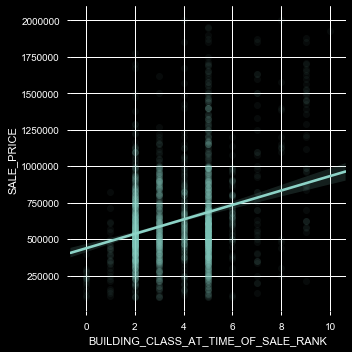

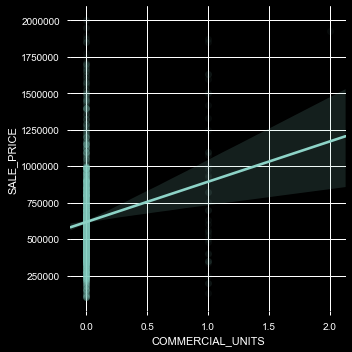

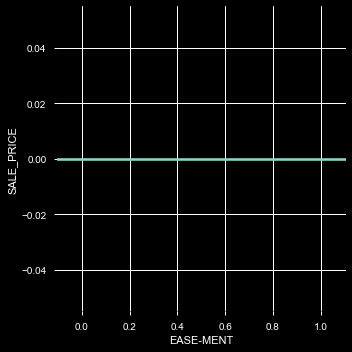

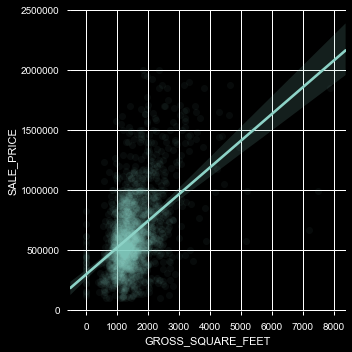

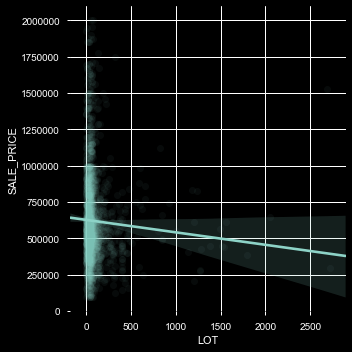

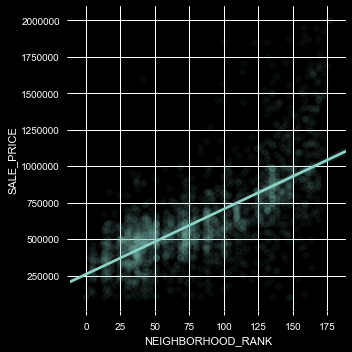

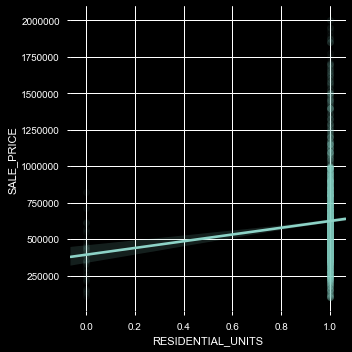

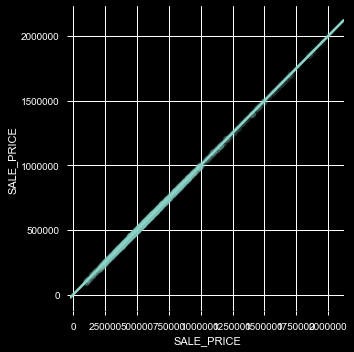

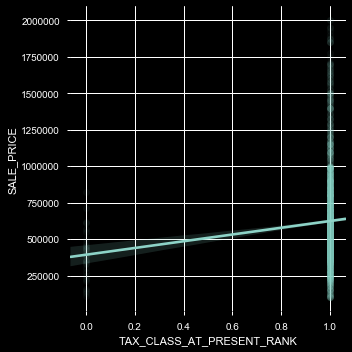

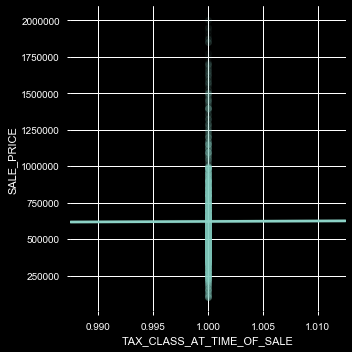

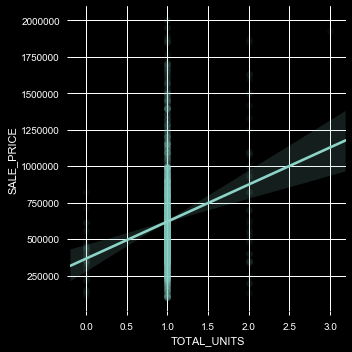

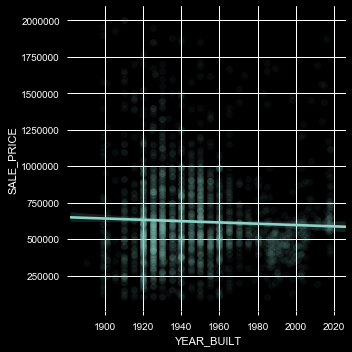

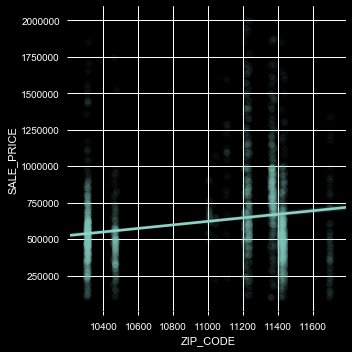

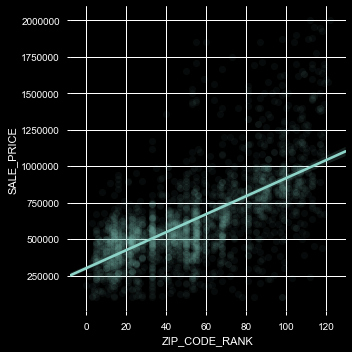

In [53]:
# Plots for continuous or rankish data
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'SALE_PRICE', data = train, scatter_kws = dict(alpha=0.05))
    plt.show()

In [54]:
# Establish features and target
target = 'SALE_PRICE'
features = train.columns.drop(['SALE_PRICE','ADDRESS','NEIGHBORHOOD','BUILDING_CLASS_CATEGORY',
                               'TAX_CLASS_AT_PRESENT','BUILDING_CLASS_AT_PRESENT','EASE-MENT',
                               'APARTMENT_NUMBER','LAND_SQUARE_FEET','TAX_CLASS_AT_TIME_OF_SALE',
                               'BUILDING_CLASS_AT_TIME_OF_SALE','SALE_DATE'])

# Feature target split
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [56]:
features

Index(['BOROUGH', 'BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'BOROUGH_RANK', 'NEIGHBORHOOD_RANK', 'TAX_CLASS_AT_PRESENT_RANK',
       'BUILDING_CLASS_AT_PRESENT_RANK', 'ZIP_CODE_RANK',
       'BUILDING_CLASS_AT_TIME_OF_SALE_RANK'],
      dtype='object')

In [109]:
# Selecting best features

selector = SelectKBest(score_func=f_regression, k = 7)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((2517, 7), (647, 7))

In [110]:
X_train_selected

array([[1.1230e+04, 1.3250e+03, 4.0000e+00, ..., 4.0000e+00, 1.0800e+02,
        4.0000e+00],
       [1.1427e+04, 2.0010e+03, 2.0000e+00, ..., 5.0000e+00, 4.6000e+01,
        5.0000e+00],
       [1.0461e+04, 2.0430e+03, 0.0000e+00, ..., 5.0000e+00, 3.8000e+01,
        5.0000e+00],
       ...,
       [1.0302e+04, 1.8070e+03, 1.0000e+00, ..., 5.0000e+00, 1.1000e+01,
        5.0000e+00],
       [1.0305e+04, 6.2100e+02, 1.0000e+00, ..., 3.0000e+00, 4.7000e+01,
        3.0000e+00],
       [1.1429e+04, 1.1630e+03, 2.0000e+00, ..., 6.0000e+00, 2.8000e+01,
        6.0000e+00]])

In [111]:
# List selected features

all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]

for name in selected_names:
    print(name)

Features selected:
ZIP_CODE
GROSS_SQUARE_FEET
BOROUGH_RANK
NEIGHBORHOOD_RANK
BUILDING_CLASS_AT_PRESENT_RANK
ZIP_CODE_RANK
BUILDING_CLASS_AT_TIME_OF_SALE_RANK


In [112]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Test MAE: {mae:,.0f}')
print(f'Test R^2: {r2}')

Test MAE: $148,741
Test R^2: $0.43656349700574726
